In [1]:
from dinov2.models import DINOv2

In [2]:
import torch

dinov2 = DINOv2.from_pretrained(
    'KevinCha/dinov2-vit-small-remote-sensing',
    device_map=0,
    torch_dtype=torch.float32,
)
dinov2 = dinov2.eval()

In [3]:
from huggingface_hub import hf_hub_download

filename = hf_hub_download(repo_id='KevinCha/dinov2-vit-small-remote-sensing', filename='test.png')
img1 = filename
img2 = filename

In [4]:
import torchvision

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((720, 720)),
    torchvision.transforms.RandomCrop((480, 480)),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.GaussianBlur(kernel_size=21),
    torchvision.transforms.ColorJitter(
        brightness=(0.875, 1.125),
        contrast=(0.5, 1.5),
        saturation=(0.5, 1.5),
        hue=(-0.05, 0.05),
    ),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

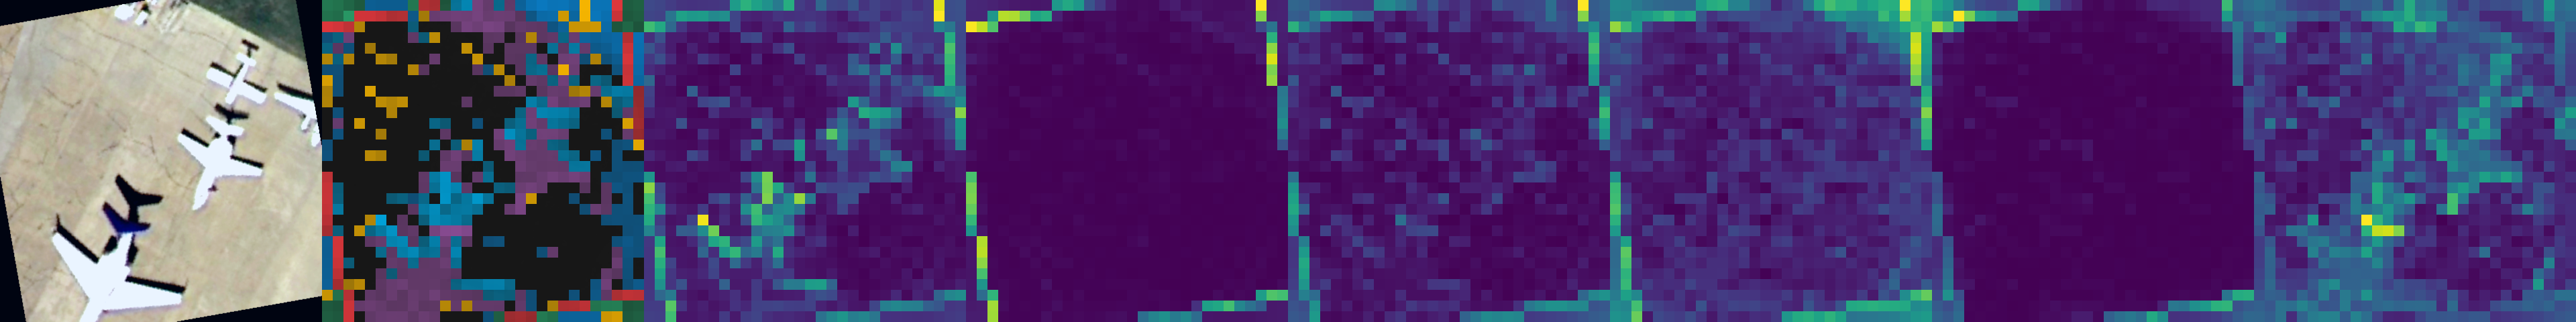

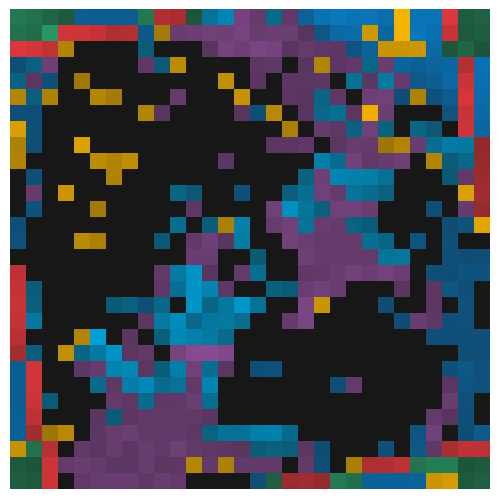

In [5]:
import numpy as np
import os
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt

company_colors = [
    (0,160,215), # blue
    (220,55,60), # red
    (245,180,0), # yellow
    (10,120,190), # navy
    (40,150,100), # green
    (135,75,145), # purple
]
company_colors = [(float(c[0]) / 255.0, float(c[1]) / 255.0, float(c[2]) / 255.0) for c in company_colors]

def apply_mask2(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    t= 0.2
    mi = np.min(mask)
    ma = np.max(mask)
    mask = (mask - mi) / (ma - mi)
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * np.sqrt(mask) * (mask>t))+ alpha * np.sqrt(mask) * (mask>t) * color[c] * 255
    return image

def show_attn(img, index=None):
    w_featmap = img.shape[-2] // 16
    h_featmap = img.shape[-1] // 16

    with torch.no_grad():
        attentions = dinov2.student.backbone.get_last_attention(img).x_lastlayer_attn_patchtokens
    nh = attentions.shape[1]
    attentions = attentions[0, :, 0, 1 + dinov2.config.num_register_tokens:].reshape(nh, -1)

    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - 0.6)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()

    # save attentions heatmaps
    prefix = f'id{index}_' if index is not None else ''
    os.makedirs('pics/', exist_ok=True)
    torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join('pics/', "img" + ".png"))
    img = Image.open(os.path.join('pics/', "img" + ".png"))

    attns = Image.new('RGB', (attentions.shape[2] * nh, attentions.shape[1]))
    for j in range(nh):
        fname = os.path.join('pics/', "attn-head" + str(j) + ".png")
        plt.imsave(fname=fname, arr=attentions[j], format='png')
        attns.paste(Image.open(fname), (j * attentions.shape[2], 0))

    return attentions, th_attn, img, attns


def show_attn_color(image, attentions, th_attn, index=None, head=[0,1,2,3,4,5]):
    M = image.max()
    m = image.min()
    span = 64
    image = ((image - m) / (M-m)) * span + (256 - span)
    image = image.mean(axis=2)
    image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    
    for j in head:
        m = attentions[j]
        m *= th_attn[j]
        attentions[j] = m
    mask = np.stack([attentions[j] for j in head])
    
    blur = False
    contour = False
    alpha = 1
    figsize = tuple([i / 100 for i in [480, 480]])
    fig = plt.figure(figsize=figsize, frameon=False, dpi=100)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    if len(mask.shape) == 3:
        N = mask.shape[0]
    else:
        N = 1
        mask = mask[None, :, :]

    # AJ
    for i in range(N):
        mask[i] = mask[i] * ( mask[i] == np.amax(mask, axis=0))
    a = np.cumsum(mask, axis=0)
    for i in range(N):
        mask[i] = mask[i] * (mask[i] == a[i])

    colors = company_colors[:N]

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = 0.1*image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask2(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros(
                (_mask.shape[0] + 2, _mask.shape[1] + 2))#, dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    ax.axis('image')
    #fname = os.path.join(output_dir, 'bnw-{:04d}'.format(imid))
    prefix = f'id{index}_' if index is not None else ''
    fname = os.path.join('pics/', "attn_color.png")
    fig.savefig(fname)
    attn_color = Image.open(fname)
    return attn_color


img = transforms(Image.open(img1).convert('RGB'))
# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % 16, img.shape[2] - img.shape[2] % 16
img = img[:, :w, :h].unsqueeze(0).to('cuda')
attentions, th_attn, pic_i, pic_attn = show_attn(img)
pic_attn_color = show_attn_color(img[0].permute(1, 2, 0).cpu().numpy(), attentions, th_attn)
final_pic = Image.new('RGB', (pic_i.size[1] * 2 + pic_attn.size[0], pic_i.size[1]))
final_pic.paste(pic_i, (0, 0))
final_pic.paste(pic_attn_color, (pic_i.size[1], 0))
final_pic.paste(pic_attn, (pic_i.size[1] * 2, 0))
display(final_pic)

In [6]:
img2 = transforms(Image.open(img2).convert('RGB'))
w, h = img2.shape[1] - img2.shape[1] % 16, img2.shape[2] - img2.shape[2] % 16
img2 = img2[:, :w, :h].unsqueeze(0).to('cuda')

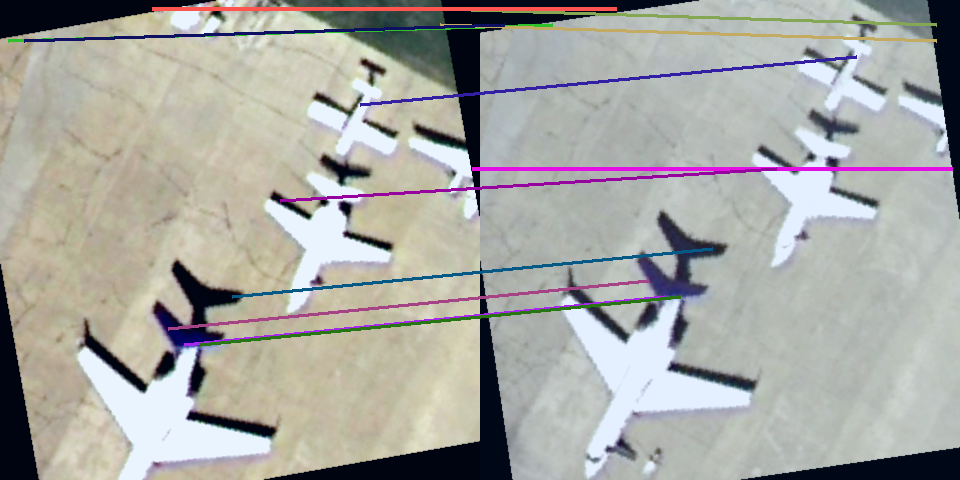

In [7]:
from PIL import ImageDraw

with torch.no_grad():
    img1_output = dinov2.student.backbone.get_last_attention(img)
    img2_output = dinov2.student.backbone(img2)

    attentions = img1_output.x_lastlayer_attn_alltokens
    attentions = attentions[:, :, 0, 1 + dinov2.config.num_register_tokens:]
    attentions = attentions.view(1, -1, img.shape[-2] // dinov2.config.patch_size, img.shape[-1] // dinov2.config.patch_size)
    attentions1 = nn.functional.interpolate(attentions, scale_factor=1.0, mode="nearest")

    attentions = attentions.mean(1, keepdim=True)
    attentions1 = attentions1.mean(1, keepdim=True)

    x1 = img1_output.x_norm_patchtokens
    x2 = img2_output.x_norm_patchtokens
    
    sim_matrix = torch.bmm(x1, x2.permute(0, 2, 1))

    value, index = sim_matrix.max(-1)

    for id, im1, im2, attention, attention1, in zip(index, img, img2, attentions, attentions1):
        for nh in range(attention.size(0)):
            attn = attention[nh]
            attn1 = attention1[nh].flatten()
            
            st = attn1.topk(12)[1]
            
            point1 = st
            point2 = id[st]
            
            i1 = torchvision.utils.make_grid(im1, normalize=True, scale_each=True)
            i1 = Image.fromarray(i1.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy())
            i2 = torchvision.utils.make_grid(im2, normalize=True, scale_each=True)
            i2 = Image.fromarray(i2.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy())
            full_img = Image.new('RGB', (480 * 2, 480))
            draw = ImageDraw.Draw(full_img)
            unit = 480 // 16
            full_img.paste(i1, (0, 0))
            full_img.paste(i2, (480, 0))

            palettes = [
                (np.random.choice(255), np.random.choice(255), np.random.choice(255))
            for _ in range(len(point1))]
            for p1, p2, palette in zip(point1, point2, palettes):
                p1y, p1x = p1 // unit + 0.5, p1 % unit + 0.5
                p2y, p2x = p2 // unit + 0.5, p2 % unit + 0.5
                draw.line((p1x * 16, 
                         p1y * 16, 
                         p2x * 16 + 480, 
                         p2y * 16), width=4, fill=palette)
            display(full_img)